# Decision Tree and Random Forest

## Table of Content 

- [Imports](#imports)
- [Data](#data)
- [Train Test Split](#train-test-split)
- [Unrestricted Tree](#unrestricted-tree)
- [Grid Search For Regularization Hyper-parameters](#grid-search-for-regularization-hyper-parameters)
- [Regularized Tree](#regularized-tree)
- [Random Forest Classifier](#random-forest-classifier)
    - [Step 1](#step-1)
    - [Step 2](#step-2)
    - [Step 3](#step-3)
    - [Step 4](#step-4)


## Imports

In [2]:
# Interactive shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data wrangling and standard library
import os
import pandas as pd
import numpy as np

# Machine learning
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from scipy.stats import mode

# Plotting
import matplotlib.pyplot as plt
from graphviz import Source
from sklearn.tree import export_graphviz

## Data

In [32]:
# Generate data
X, y = make_moons(n_samples=10000, noise=0.4, random_state=12)
X
y

array([[-0.0472689 ,  0.23142803],
       [ 1.28658871,  0.29938948],
       [-0.57518336,  0.09778237],
       ...,
       [-0.62962102,  0.84830541],
       [ 1.81261979,  0.14332072],
       [ 0.50097383,  0.37488696]])

array([1, 1, 0, ..., 0, 1, 1])

## Train Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_test, y_train, y_test

(array([[ 1.69090932,  0.28346745],
        [ 0.98066331, -0.74955928],
        [-1.0907285 ,  0.59524581],
        ...,
        [-0.5466909 , -0.421264  ],
        [-0.36370025,  1.11001275],
        [ 1.18277893,  1.32182963]]),
 array([[-0.01237358, -0.00352215],
        [-0.21493067,  1.50382965],
        [-0.00408199,  1.16923089],
        ...,
        [ 0.17604024,  0.9295566 ],
        [-0.30944764, -0.04688371],
        [ 1.55102924, -0.62339588]]),
 array([1, 1, 0, ..., 1, 0, 0]),
 array([1, 0, 0, ..., 0, 1, 1]))

In [34]:
# Shapes
X_train.shape, y_train.shape

((8000, 2), (8000,))

In [35]:
# Unique class labels
np.unique(y_train)

array([0, 1])

## Unrestricted Tree

If left unrestrained, the decision tree classifier will have a depth of $\log_{2}(8000)\approx12.97\approx13$ (or 13 internal or children nodes from the top to a terminal node) or more.

In [9]:
# Unconstrained tree
unrestricted_tree = DecisionTreeClassifier(random_state=12).fit(X_train, y_train)

In [10]:
# Export visualization
export_graphviz(
        unrestricted_tree,
        out_file='../plots/unrestricted_tree.dot',
        feature_names=['var1', 'var2'],
        class_names=['0_group', '1_group'],
        rounded=True,
        filled=True
    )
Source.from_file('../plots/unrestricted_tree.dot')

## Grid Search For Regularization Hyper-parameters

In [36]:
# Dictionary of hyperparameters
# The minimum number of samples required to be at a leaf node
# The maximum number of leaf nodes
# Try 294 (98 × 3) combinations of hyperparameters
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

# Grid search estimator
grid_search_cv = GridSearchCV(estimator=DecisionTreeClassifier(random_state=12), param_grid=params, verbose=1, cv=3)

# Search
grid_search_cv.fit(X_train, y_train)


Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    6.1s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=12),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

## Regularized Tree

In [37]:
# Estimator with tuned hyperparameter
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=23, random_state=12)

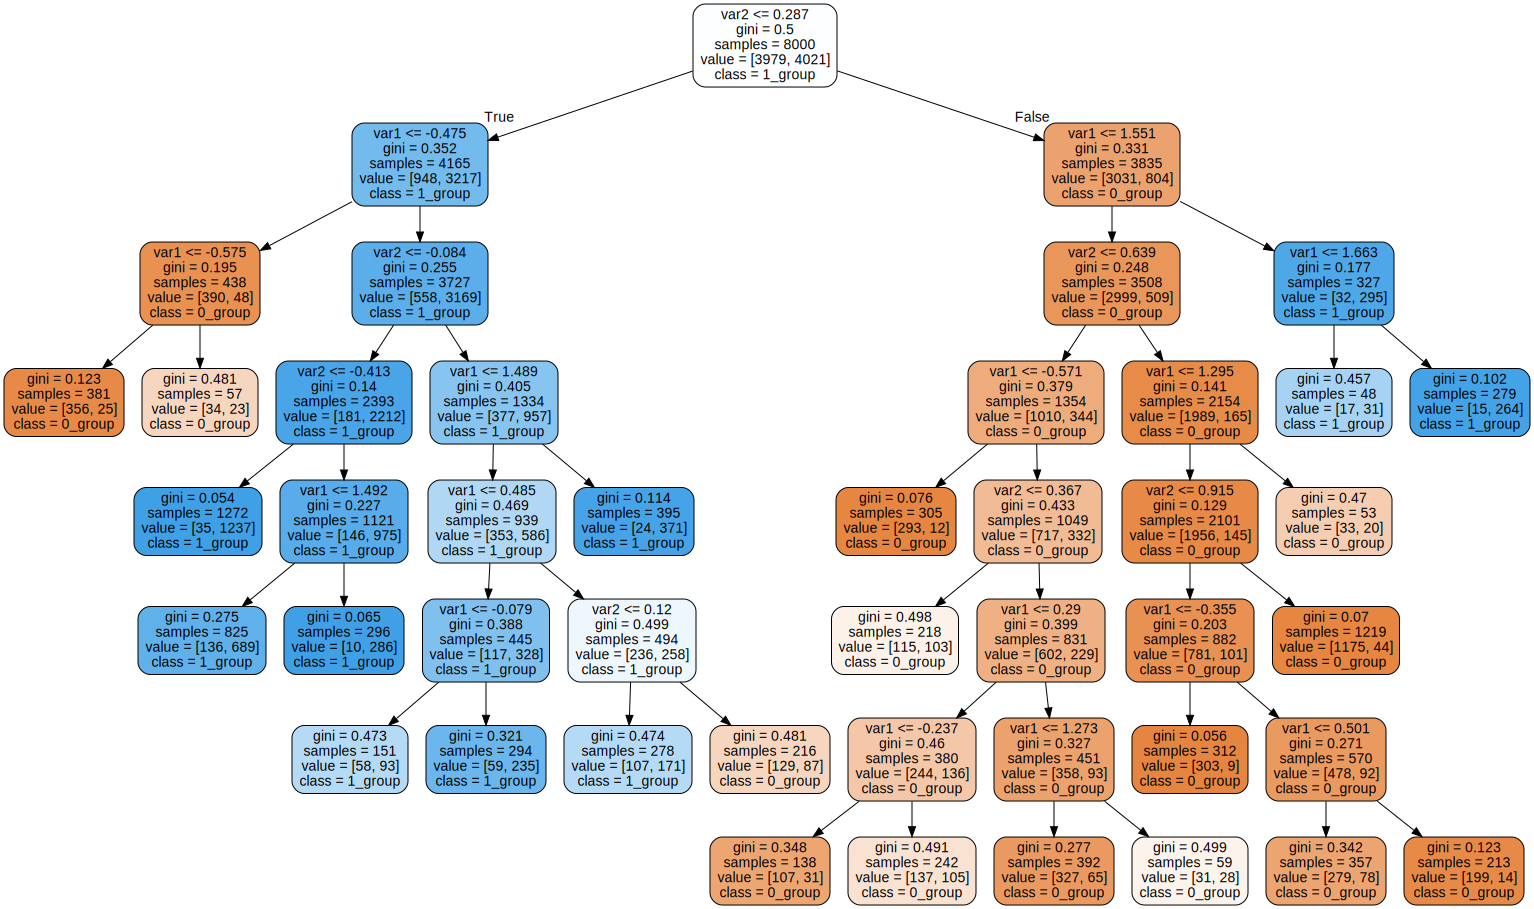

In [13]:
# Visualize
export_graphviz(
        grid_search_cv.best_estimator_,
        out_file='../plots/regularized_tree.dot',
        feature_names=['var1', 'var2'],
        class_names=['0_group', '1_group'],
        rounded=True,
        filled=True
    )
Source.from_file('../plots/regularized_tree.dot')

In [38]:
# Predictions
y_pred = grid_search_cv.predict(X_test)
# Returns the fraction of correctly classified samples
accuracy_score(y_true=y_test, y_pred=y_pred)

0.8585

## Random Forest Classifier

We would take the following steps:

* Generate 1,000 subsets of the training set (8,000 samples), each containing 100 instances selected randomly.

* Train one Decision Tree (weak learner) on each subset, using the best hyperparameter values above. Evaluate these 1,000 Decision Trees on the test set (2000 samples).

* For each of the 2,000 test set instance, generate the predictions using all 1,000 Decision Trees for a total of $2,000 \times 1,000 = 2,000,000$ predictions. For each of the 2,000 test instance, keep only the most frequent prediction among the 1,000 predictions, obtaining a *majority-vote* prediction for each test instance.

* Last, we evaluate the accuracy of prediction by comparing the true target labels ($2,000$ test instance) and the *majority-vote* predictions ($2,000$ predictions). Note that each of the $2,000$ predictions is actually the most frequently observed value among all `1,000` *weaker* predictions.  

#### Step 1 <a class="anchor" id="step-1"></a>

In [39]:
# Number of subsets
n_trees = 1000
# Number of instance per subset
n_instances = 100

# Instantiate container for 1000 train, test splits
set_of_splits = []

# Generator for splitting
random_split = ShuffleSplit(
    # Split training set into 1000 subsets
    n_splits=n_trees, 
    # Number of test samples (8000 - 100 = 7900), leaving 100 training samples for each split subset
    test_size=len(X_train) - n_instances, 
    random_state=12
)

# At each step, the generator returned by 'random_split.split()' returns two numpy arrays
# The indices for training data (len = 100) and indices for test data (len = 7900)
# A total of 1000 splits
for train_index, test_index in random_split.split(X_train):
    # Randomly draw instances from X_train and y_train 
    X_subset_train = X_train[train_index]
    y_subset_train = y_train[train_index]
    # Store each pairing as a tuple
    set_of_splits.append((X_subset_train, y_subset_train))

In [40]:
len(set_of_splits)

1000

### Step 2 <a class="anchor" id="step-2"></a>

`Clone` constructs a new unfitted estimator with the same parameters. This function does a deep copy of the model in an estimator without actually copying attached `data`. It returns a new estimator with the same parameters that has not been fitted on any data.

In [41]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [42]:
# List of unfitted DecisionTreeClassifier estimators with tuned hyperparameters
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

# Instantiate container for scores
accuracy_scores = []

# At each iteration, set_of_splits's iterator returns a tuple of two numpy arrays
# We tuple assign this tuple to two variables 'X_subset_train' and 'y_subset_train'
# Total of 1000 iterations
for tree_estimator, (X_subset_train, y_subset_train) in zip(forest, set_of_splits):
    # Train a weak learner tree on just the 100 instances of training data
    tree_estimator.fit(X_subset_train, y_subset_train)
    # Make predictions using the weak learner on the entire test set (2000)
    y_pred = tree_estimator.predict(X_test)
    # Obtain scores
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Average score of the 1000 weak learners
np.mean(accuracy_scores)

0.789467

In [43]:
InteractiveShell.ast_node_interactivity = "all"

### Step 3 <a class="anchor" id="step-3"></a>

In [44]:
# Shape of container for predictions
# 100 rows and 2000 columns
(n_trees, len(X_test))

(1000, 2000)

In [45]:
# Initialize container for predictions
y_pred = np.empty(shape=(n_trees, len(X_test)), dtype=np.uint8)
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [46]:
# For each weak learning in 'forest', predict on entire test set (2000)
for tree_index, tree in enumerate(forest):
    y_pred[tree_index] = tree.predict(X_test)

In [47]:
y_pred

array([[1, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1]], dtype=uint8)

The `mode` function returns two objects--- `mode` (an `ndarray` of modal values) and `count` (another `ndarray` of counts for each mode value in `mode`). We also specify `axis=0`, which means we find mode values vertically along the columns of the matrix of predictions. Each column of the matrix `y_pred` contains $1,000$ predictions made by all $1,000$ weak leaner trees.

In [48]:
y_pred_majority_votes, n_votes = mode(y_pred, axis=0)
y_pred_majority_votes
n_votes

array([[1, 0, 0, ..., 0, 1, 1]], dtype=uint8)

array([[790, 929, 904, ..., 907, 653, 978]])

The example we have is a binary classification problem, and so the predicted class label is either $1$ or $0$. The outputs above are understand as follows:

* In the first column, the label `1` appeared most frequently; 790 weak learner trees from among $1,000$ predicted that this test instance belongs to the class with label `1`.

* In the second column, the label `0` appeared most frequently; 929 weak learner trees from among $1,000$ predicted that this test instance belongs to the class with label `0`.

* In the third column, the label `0` again appeared most frequently; 904 weak learner trees from among $1,000$ predicted that this test instance belongs to the class with label `0`.

* So on and so forth ...

### Step 4 <a class="anchor" id="step-4"></a>

In [49]:
accuracy_score(y_test, y_pred_majority_votes[0])


0.866

This is a $0.866 - 0.8585=0.0075 \times 100=0.75$ percentage point increase in prediction accuracy.